In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
sys.path.append('scat_tf')
from scat_tf import scattering
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from math import ceil, floor
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 6)

# make scat

In [2]:
J = 2 # spatial scale of filter
L = 8 # number of angular orientations
M, N = 32, 32 # dimensions
scat = scattering.Scattering(M=M, N=N, J=J, L=L) 

# make scat_comp
num_channels = 1 # grayscale or color input
placeholder = tf.placeholder(tf.float32, (1, num_channels, M, N)) # requires NCHW format (cuDNN default - tf is NHWC)
scat_comp = scat(placeholder)
output_middle = floor(scat_comp.shape[-1] / 2)
print("J", J, "L", L, "M", M, "N", N, 'input', placeholder.shape, 'output', scat_comp.shape)
print('expected num filts', int(num_channels * (1 + J* L + J * (J-1) * L * L /2)))

J 2 L 8 M 32 N 32 input (1, 1, 32, 32) output (1, 81, 8, 8)
expected num filts 81


# max activation

In [ ]:
# normalize an image
def visstd(a, s=0.1): 
    return s * (a - a.mean()) / max(a.std(), 1e-4) + 0.5

# calculate maximum activating input
def get_filt(scat_comp, placeholder, filt_num, output_middle, step = 250, step_decay = 1, num_iters = 40):
    # set up tf vars
    t_score = tf.reduce_mean(scat_comp[0, filt_num, output_middle, output_middle]) # objective, maximize middle
    t_grad = tf.gradients(t_score, placeholder)[0]                 # gradient
    im_noise = np.random.uniform(size=(M, N, num_channels)) * 0.01 # generate noise
    im_tf = np.expand_dims(np.transpose(im_noise, (2, 0, 1)), 0)   # convert it to tf tensor

    # gradient ascent
    for i in range(num_iters):
        g, score = sess.run([t_grad, t_score], {placeholder: im_tf})
        im_tf += g * step
        step *= step_decay
        
    # return MxN ndarray
    im_out = np.transpose(np.array(im_tf)[0, 0], (1, 0)) 
    return visstd(im_out)

# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# get filts
num_filts = int(scat_comp.shape[1])
filts = np.empty(shape=(num_filts, M, N)) # divide by number of colors
for filt_num in tqdm(range(num_filts)):
    filts[filt_num] = get_filt(scat_comp, placeholder, filt_num, output_middle)
    
# save filts
out_file = '/scratch/users/vision/chandan/out/scat/' + '_'.join(['filts_00', 'J='+str(J), 'L='+str(L), 
                                                                'M='+str(M), 'N='+str(N)])
np.save(out_file, filts)

 40%|███▉      | 32/81 [21:37<44:25, 54.39s/it]

# visualize

In [ ]:
# show filts
def show(x):
    plt.imshow(x, interpolation='None', cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 12))
num_cols = 8
num_rows = ceil(num_filts / num_cols)

for filt_num in range(num_filts):
    plt.subplot(num_rows, num_cols, filt_num + 1)
    show(filts[filt_num])
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

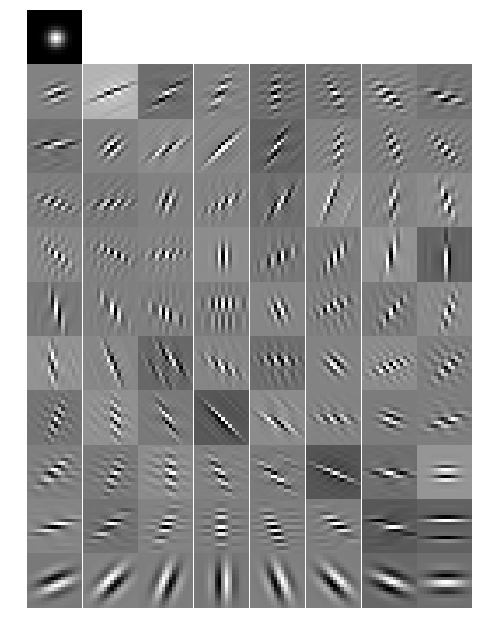

In [11]:
def show(x):
    plt.imshow(x, interpolation='None', cmap='gray')
    plt.axis('off')

filt_file = 'filts/filts_save_middle_J=2_L=8_M=32_N=32.npy'
# filt_file = 'filts/filts_save_00_J=2_L=8_M=32_N=32.npy'
filts = np.load(filt_file)
num_filts = filts.shape[0]

# show filts
plt.figure(figsize=(8, 11))
num_cols = 8
num_rows = ceil(num_filts / num_cols)

# crop
b = 8
filts = [filts[i][b:-b, b:-b] for i in range(filts.shape[0])]

# plot
plt.subplot(num_rows, num_cols, 1)
show(filts[0])
for filt_num in range(1, num_filts):
    plt.subplot(num_rows, num_cols, num_cols + filt_num)
    show(filts[filt_num])
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()